In [1]:
import pandas as pd

In [2]:
import torch
torch.set_default_dtype(torch.float64)

import numpy as np

In [3]:
df = pd.read_hdf('freesolv_with_samples.h5')

In [4]:
from openmmtools.constants import kB
from simtk import unit
from espaloma.units import DISTANCE_UNIT, ENERGY_UNIT

temperature = 300 * unit.kelvin
kT = kB * temperature

# conversion from espaloma energy unit to kT
to_kT = 1.0 * ENERGY_UNIT / kT
to_kT

Using backend: pytorch


1052.5821686494048

In [5]:
df['offmol']['mobley_1017962'].partial_charges

Quantity(value=array([-0.09266   , -0.07967   , -0.07829   , -0.07824   , -0.12671   ,
        0.63147002, -0.53658998, -0.44984001,  0.12808   ,  0.03392   ,
        0.03392   ,  0.03392   ,  0.04138   ,  0.04138   ,  0.03957   ,
        0.03957   ,  0.05656   ,  0.05656   ,  0.07839   ,  0.07839   ,
        0.04963   ,  0.04963   ,  0.04963   ]), unit=elementary charge)

In [6]:
from scipy.spatial.distance import pdist, squareform

# these are espaloma units of bohr
df['distance_matrices'] = None

for key in df.index:
    xyz = (df['quick_xyz'][key] * unit.nanometer).value_in_unit(DISTANCE_UNIT)
    distance_matrices = [torch.tensor(squareform(pdist(conf))) for conf in xyz]
    distance_matrices = torch.stack(distance_matrices)
    df['distance_matrices'][key] = distance_matrices

In [7]:
df.columns

Index(['SMILES',
       'iupac name (or alternative if IUPAC is unavailable or not parseable by OEChem)',
       'experimental value (kcal/mol)', 'experimental uncertainty (kcal/mol)',
       'Mobley group calculated value (GAFF) (kcal/mol)',
       'calculated uncertainty (kcal/mol)',
       'experimental reference (original or paper this value was taken from)',
       'calculated reference', 'text notes.', 'offmol',
       'serialized_openmm_system', 'xyz', 'quick_xyz', 'distance_matrices'],
      dtype='object')

In [8]:
from espaloma.mm.implicit import gbsa_obc2_energy

In [9]:
def compute_obc2_energies(
    distance_matrices,
    radii, scales, charges,
    alpha=0.8, beta=0.0, gamma=2.909125
):
    N = len(distance_matrices)
    E_s = torch.zeros(N)
    for i in range(N):
        E_s[i] += gbsa_obc2_energy(
            distance_matrices[i],
            radii, scales, charges, 
            alpha, beta, gamma,
        )
    return E_s

In [10]:
offmol = df['offmol'][key]

In [11]:
from espaloma.redux.nn import TAG, MLP
from espaloma.redux.symmetry import ValenceModel, Readouts, elements

# radii, scales
atom_dim = 2

def initialize(hidden_dim=128, node_dim=128):
    node_representation = TAG(in_dim=len(elements), hidden_dim=hidden_dim, out_dim=node_dim)
    readouts = Readouts(atoms=MLP(node_dim, atom_dim), bonds=MLP(2 * node_dim, 2), angles=MLP(3 * node_dim, 2),
                        propers=MLP(4 * node_dim, 6), impropers=MLP(4 * node_dim, 6))
    graph_model = ValenceModel(node_representation, readouts)
    return graph_model


def predict_obc2_params(offmol, graph_model):
    """output of graph net's atom representation will initially be near zero, just offset by a constant"""
    params = graph_model.forward(offmol)
    radii = params.atoms[:,0] + 2
    scales = params.atoms[:,1] + 1
    return radii, scales

In [40]:
def one_sided_exp(w):
    delta_f = (torch.logsumexp(- w, dim=(0,)) - np.log(len(w)))
    return delta_f

In [41]:
def predict_on_key(key: str, graph_model, batch_size: int = 25, verbose: bool = False) -> float:
    offmol = df['offmol'][key]
    
    radii, scales = predict_obc2_params(offmol, graph_model)
    
    distance_matrices = df['distance_matrices'][key]
    inds = np.random.randint(0, len(distance_matrices), size=batch_size)
    
    charges = torch.tensor(offmol.partial_charges / unit.elementary_charge)
    
    obc2_energies = compute_obc2_energies(distance_matrices[inds], radii, scales, charges)
    if verbose:
        print(obc2_energies)
    w = obc2_energies * to_kT
    pred_delta_f = one_sided_exp(w)
    
    return pred_delta_f

In [42]:
train_inds = list(df.index[::2])
len(train_inds)

321

In [43]:
train_inds

['mobley_1017962',
 'mobley_1034539',
 'mobley_1046331',
 'mobley_1079207',
 'mobley_1139153',
 'mobley_1160109',
 'mobley_1189457',
 'mobley_1231151',
 'mobley_1244778',
 'mobley_1278715',
 'mobley_1323538',
 'mobley_1328936',
 'mobley_1363784',
 'mobley_1417007',
 'mobley_1449384',
 'mobley_1502181',
 'mobley_1527293',
 'mobley_1571523',
 'mobley_1615431',
 'mobley_1650157',
 'mobley_1662128',
 'mobley_1708457',
 'mobley_1722522',
 'mobley_1728386',
 'mobley_1733799',
 'mobley_1743409',
 'mobley_1760914',
 'mobley_1781152',
 'mobley_1800170',
 'mobley_1821184',
 'mobley_1838110',
 'mobley_1855337',
 'mobley_1858644',
 'mobley_1873346',
 'mobley_1881249',
 'mobley_1893937',
 'mobley_1899443',
 'mobley_1905088',
 'mobley_1923244',
 'mobley_194273',
 'mobley_1952272',
 'mobley_1967551',
 'mobley_1976156',
 'mobley_1987439',
 'mobley_2008055',
 'mobley_2043882',
 'mobley_20524',
 'mobley_2078467',
 'mobley_210639',
 'mobley_2126135',
 'mobley_2146331',
 'mobley_2183616',
 'mobley_2198613

In [44]:
from tqdm import tqdm

In [45]:
graph_model = initialize()

preds = []
for key in tqdm(train_inds):
    preds.append(predict_on_key(key, graph_model))

 23%|██▎       | 73/321 [00:03<00:11, 21.08it/s]


KeyboardInterrupt: 

In [46]:
preds = []
for key in tqdm(train_inds):
    preds.append(predict_on_key(key, graph_model))

 18%|█▊        | 57/321 [00:02<00:09, 27.77it/s]


KeyboardInterrupt: 

In [47]:
graph_model = initialize()

In [48]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(graph_model.parameters(), lr=learning_rate)

In [49]:
# fit to a small chunk of the data
keys = train_inds[:10]
keys

['mobley_1017962',
 'mobley_1034539',
 'mobley_1046331',
 'mobley_1079207',
 'mobley_1139153',
 'mobley_1160109',
 'mobley_1189457',
 'mobley_1231151',
 'mobley_1244778',
 'mobley_1278715']

In [50]:
from openforcefield.topology import Molecule

In [51]:
df.offmol[keys[1]]

NGLWidget(max_frame=1)

In [52]:
predict_dict = dict()
for key in tqdm(keys):
    predict_dict[key] = predict_on_key(key, graph_model)

100%|██████████| 10/10 [00:00<00:00, 17.72it/s]


In [53]:
x = np.array([predict_dict[key].detach() * kT / unit.kilocalorie_per_mole for key in keys])
y = [df['experimental value (kcal/mol)'][key] for key in keys]

In [54]:
x[0], y[0]

(-2.6361914088050113, -2.49)

Text(0, 0.5, 'reference (kcal/mol)')

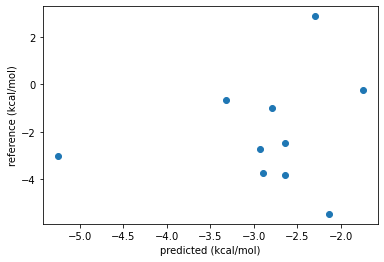

In [55]:
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.xlabel('predicted (kcal/mol)')
plt.ylabel('reference (kcal/mol)')

##### Curious that these are always predicted positive...

In [27]:
predictions = []

batch_losses = []
trange = tqdm(range(1000))

n_mols_per_batch = 10
n_snapshots_per_mol = 10


for t in trange:
    #keys = np.random.choice(train_inds, size=n_mols_per_batch)
    
    L = 0.0
    for key in keys:
        # make a free energy prediction using a random subset of snapshots for each key
        prediction  = predict_on_key(key, graph_model, n_snapshots_per_mol)
        target = (df['experimental value (kcal/mol)'][key] * unit.kilocalorie_per_mole) / kT
    
        # TODO: modify loss function to depend on experimental error and simulation error
        L += (prediction - target)**2
        predictions.append((t, key, prediction))
    
    L /= len(keys)

    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    batch_losses.append(L.detach().numpy())
    rmse_in_kcalmol = np.sqrt(batch_losses[-1] * kT / unit.kilocalories_per_mole)
    trange.set_postfix(rmse_in_kcalmol=rmse_in_kcalmol)

 19%|█▉        | 192/1000 [01:10<04:58,  2.71it/s, rmse_in_kcalmol=3.92]


KeyboardInterrupt: 

In [28]:
rmse_in_kcalmol = [np.sqrt(b * kT / unit.kilocalories_per_mole) for b in batch_losses]

(0.0, 12.340199478140512)

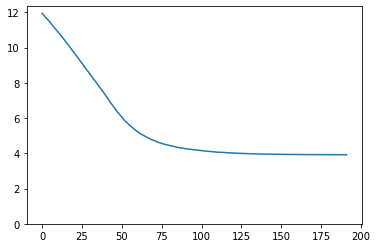

In [29]:
import matplotlib.pyplot as plt
plt.plot(rmse_in_kcalmol)
plt.ylim(0,)

In [30]:
np.mean(rmse_in_kcalmol[:100]), np.mean(rmse_in_kcalmol[-100:])

(6.94120215982174, 3.9928625043905352)

In [31]:
final_predict_dict = dict()
for key in tqdm(keys):
    final_predict_dict[key] = predict_on_key(key, graph_model, verbose=True)

 30%|███       | 3/10 [00:00<00:00, 22.46it/s]

tensor([-1.3828e-06, -9.1827e-07, -1.8550e-06, -1.2739e-06, -4.7216e-07,
        -3.6431e-07, -2.5594e-07, -3.6381e-09, -5.6672e-07, -6.7104e-07,
        -9.1827e-07,  6.0305e-08, -1.1560e-07, -7.7305e-07, -6.3373e-07,
        -8.7751e-07, -1.5999e-06, -1.4431e-06, -9.1827e-07,  1.4077e-07,
         9.2865e-09,  1.9645e-07, -8.8365e-07, -2.2221e-06,  3.7633e-08],
       grad_fn=<CopySlices>)
tensor([1.1496e-04, 1.0982e-04, 9.3960e-05, 1.1496e-04, 8.4725e-05, 8.0141e-05,
        8.2465e-05, 8.6202e-05, 9.3085e-05, 9.6847e-05, 9.7558e-05, 7.6240e-05,
        8.6118e-05, 8.2432e-05, 8.3619e-05, 7.0814e-05, 8.6105e-05, 8.5659e-05,
        9.8484e-05, 1.0471e-04, 9.5067e-05, 8.2077e-05, 9.8338e-05, 9.8338e-05,
        8.6037e-05], grad_fn=<CopySlices>)
tensor([-2.2980e-05, -1.9692e-05, -2.0390e-05, -2.1288e-05, -2.2049e-05,
        -2.2476e-05, -2.2033e-05, -2.5099e-05, -2.2978e-05, -2.3078e-05,
        -2.5413e-05, -2.1679e-05, -2.5125e-05, -2.5484e-05, -2.3379e-05,
        -1.9624e-05, -2

100%|██████████| 10/10 [00:00<00:00, 25.66it/s]

tensor([-5.9970e-06, -4.5307e-06, -3.7902e-06, -4.9577e-06, -6.2455e-06,
        -4.6468e-06, -7.3552e-06, -5.5797e-06, -7.0606e-06, -5.5797e-06,
        -6.0297e-06, -5.8646e-06, -6.0671e-06, -5.0655e-06, -5.0655e-06,
        -5.8541e-06, -5.8463e-06, -7.2681e-06, -6.4089e-06, -5.3132e-06,
        -6.6310e-06, -7.2681e-06, -6.4089e-06, -3.7902e-06, -7.2410e-06],
       grad_fn=<CopySlices>)
tensor([-5.9714e-06, -5.8022e-06, -4.9813e-06, -5.7171e-06, -5.3778e-06,
        -6.7010e-06, -4.0000e-06, -5.0278e-06, -3.8259e-06, -3.7281e-06,
        -5.4476e-06, -3.3640e-06, -4.0217e-06, -5.6084e-06, -6.0806e-06,
        -3.4821e-06, -5.2972e-06, -3.8847e-06, -3.8847e-06, -4.1225e-06,
        -3.8847e-06, -5.6084e-06, -4.0383e-06, -4.9115e-06, -5.8901e-06],
       grad_fn=<CopySlices>)
tensor([-6.9196e-07, -1.4105e-06, -6.9762e-07, -6.6031e-07, -1.0309e-06,
        -1.4105e-06, -3.0493e-06, -4.2932e-06, -2.9701e-06, -1.3380e-06,
        -2.6319e-06, -6.5646e-06, -5.5980e-06, -3.1515e-06, -2.8

In [34]:
x = np.array([final_predict_dict[key].detach() * kT / unit.kilocalorie_per_mole for key in keys])
y = [df['experimental value (kcal/mol)'][key] for key in keys]

Text(0.5, 1.0, 'GBSA hydration free energies')

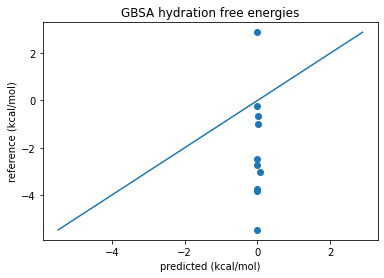

In [38]:
plt.scatter(x, y)
plt.xlabel('predicted (kcal/mol)')
plt.ylabel('reference (kcal/mol)')
plt.plot([min(y), max(y)], [min(y), max(y)])

plt.title('GBSA hydration free energies')

In [39]:
min(x)

-0.013936956823974436

So it looks like it's having a really hard time making negative predictions, for some reason...